# Clustering
## introduction
This tutorial will introduce you to some basic methods of cluster analysis. Cluster anaylsis, also known as clustering, divides data into groups(clusters) such that the data in each group will have similar meaning [1]. Clustering is used in different industries, for example, biology, medicine or marketing. Here are some typical applications using clustering:
- Image segmentation
- Recommender systems
- Market research...

## Tutorial Content
In this tutorial, we will introduce two basic technics involved in cluster analysis using Python: k-means clustering and DBSCAN. 

We will cover the following topics in this tutorial:
- Load and process data
- K-means Algorithm
- K-means++ Algorithm
- DBSCAN

In [31]:
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.sparse as sp

## Load and process data
First, we need to load data from the file. The file contains two or more columns. Only the first two are useful. The first column is a coordinate X and the second column is coordinate Y. Load the file and save each point as a list with X and Y. Then store all the points as a np array

In [32]:
def load_file(filename):
    """
    Args:
        filename: the file to load. The first column of the file is X and the second column of the file is Y

    Returns:
        result: list of list[float, float], the first element is latitude and the second
           element is lontitude
    """

    lines = [[float(num) for num in line.rstrip('\n').split()[:2]] for line in open(filename)]
    return np.array(lines)

In [33]:
points = load_file("test_data.txt")

After loading all the points, let's plot them. The following function will plot all the points. It can also plot clusters and centroids with different colors (we will use it later)

In [34]:
def plot_cluster(points, clusters = None, centroids = None, multiple = False):
    if multiple == False:
        plt.clf()
        plt.gca().set_aspect('equal', adjustable='box')
    if clusters is None:
        plt.scatter(points[:,0], points[:,1], c='blue', s=1, edgecolors='blue')
    else:
        K = len(clusters)
        colors = cm.rainbow(np.linspace(0, 1, K))
        for key, value in clusters.iteritems():
            if len(value) > 0:
#                 plt.scatter(value[:,0], value[:,1], color = np.random.rand(3,1), s=1)
                plt.scatter(value[:,0], value[:,1], color = colors[key], s=1)

    
    if centroids is not None:
        plt.scatter(centroids[:,0], centroids[:,1], c='black', s=100, edgecolors='black')
    pass


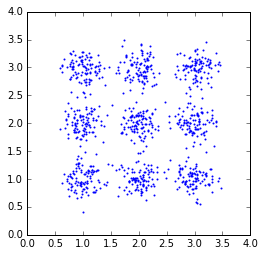

In [35]:
plot_cluster(points)

## K-means
K-means clustering, also called centroid-based clustering, attempts to find a user-specific number of clusters(K), which are represented by their centroid [2]. The points will be assigned to its closest centroid and all these points will belong to one cluster. Here is a detailed step of this algorithm:
1. Select K random point as initial points
2. K clusters are created by all the points with the nearest mean (the smallest Euclidean distance) 
3. Calculate the new centroid
4. Repeat step 2 and 3 until the centroids do not change

This algorithm aims to minimize an objective function, in this case a squared error function: $$SSE = \sum_{i=1}^K \sum_{x \in C_i} dist(c_i,x)^2 $$

In [51]:
class K_means():
    def __init__(self, points, K):
        """
        points (ndarray): all the points we need to cluster
        k (int): the number of clusters
        centroids (list): list of centroids
        clusters (dict): A dictionary of cluster mapped from cluster number (int) to array of points (ndarray) 
        
        """
        self.points = points
        self.k = K
        self.centroids = np.array([])
        self.clusters = {}
    
    def objective(self):
        return sum([sum([sum((point - self.centroids[key])**2) for point in cluster]) for key, cluster in self.clusters.iteritems()])

    def initialize_centroids(self):
        """
        Initialize K random centroids from points

        """
        sample = random.sample(range(1, self.points.shape[0]), self.k)
        self.centroids = np.array([[self.points[pt][0], self.points[pt][1]] for pt in sample])
        pass
    
    def form_cluster(self):
        """
        Build cluster based on centroids

        """
        e_dist = np.power(self.points - self.centroids[:, np.newaxis],2).sum(axis = 2)
        min_index = np.argmin(e_dist, axis=0)

        for i in set(min_index):
            self.clusters[i] = self.points[min_index == i]
        pass

    def recompute_centroids(self):
        """
        Recomputer centroid based on cluster

        Args:
            points: list of all the points we need to cluster
            clusters: dict of cluster index and all the point for each cluster
            centroids: list of all the centroids

        Returns:
            result: np.array
                new list of centroids.
        """
        self.centroids = np.array([np.mean(value, axis = 0) for key, value in self.clusters.iteritems()])
        pass
    
    def k_means(self, centroids = None, verbose = False):
        """ Compute the K-means of list of points
        
        Returns: Tuple of two items
            List<Tuple(float, float)>: 
                The first element is a dict of clusters. The data is the same as form_cluster function
                The second element is a np.array of centroids. The data is the same as recomputer_centroids

        """
        iters = 0
        
        # create K random centroids
        if centroids is None:
            self.initialize_centroids()
        else:
            self.centroids = centroids

        # record centroids before recomputing
        prev_cent = []

        # if the centroid does not change, stop the loop
        while (np.array_equal(prev_cent,self.centroids) is False):
            
            # print objective value
            if verbose:
                print '{0}:\t {1}'.format(iters, self.objective())
                iters += 1
            
            prev_cent = self.centroids

            # create a cluster with the point and its closet centroid
            self.form_cluster()

            # recompute centroid based on the clusters
            self.recompute_centroids()

        return (self.clusters, self.centroids)
        pass

In [52]:
k_means = K_means(points, 9)

### Centroid Initialization
The first step of K-means is to pick K random points from all the points as centroids. We are going to plot these centroids. Run the plotting code several times and you will find that sometimes the centroids are not well distributed.

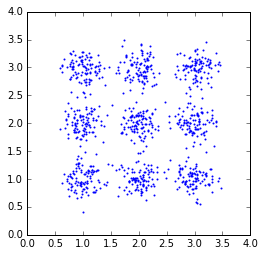

In [53]:
centroids = k_means.initialize_centroids()

plot_cluster(points, None, centroids)

### Form Cluster
After initializing the centroids, we need to form the cluster.
1. Calculate the Euclidean distance from each point to each centroid. However, since we only use these values to do the comparison, we do not need to calculate the square root. For example, there is a point (1,2) and two centroids (3,4) and (5,6). Then we will get two results after the calculation: 8 and 32
2. Find the centroid with the smallest distance for each point. So for point (1,2), centroid (3,4) has the smallest Euclidean distance.
3. Combine all the points with the same smallest centroid into one group
We will plot the points with different colors based on which cluster they are in. Each cluster will have the same color.

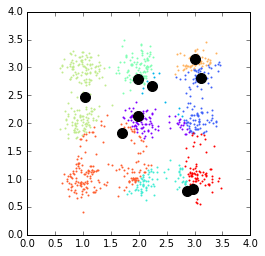

In [54]:
k_means.form_cluster()

plot_cluster(points, k_means.clusters, k_means.centroids)

### Recomputer Centroids
After finding the clusters based on centroids, we need to re-compute the mean point of all the points within one cluster. The mean point of all the points is the mean value of X of all the points and the mean value of Y of all the points. The mean point will become the new centroid of this cluster. We need to re-compute centroid for all the clusters.

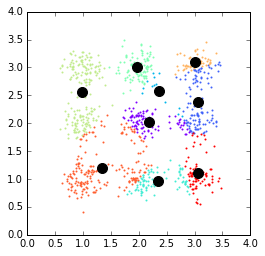

In [55]:
k_means.recompute_centroids()

plot_cluster(points, k_means.clusters, k_means.centroids)

### Compute K-means
Once we are done with re-computing centroid, we need to repeat forming cluster since centroid changed and re-compute centroid since cluster changed. We will repeat this process until the centroid remains unchanged.

0:	 2356.94492658
1:	 141.164776914
2:	 115.854218214
3:	 106.057813991
4:	 104.208531498
5:	 102.708470494
6:	 101.903813726
7:	 101.265564466
8:	 100.734445017
9:	 100.568905755
10:	 100.468841183
11:	 100.310421141
12:	 100.162789064
13:	 100.052503725
14:	 99.8000003782
15:	 99.5981914436
16:	 99.4799477189
17:	 99.4615327366


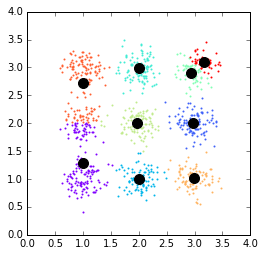

In [56]:
clusters, centroids = k_means.k_means(verbose = True)

plot_cluster(points, clusters, centroids)

You will find that the objective value decreases until it remains the same, which means the centroids does not change any more

## K-means ++
If you run the previous program for several times, you will find that the clusters are different each time. One of the key factors that affect the result is our initial state. Since we pick the initial centroids randomly, it is possible that the initial centroids are not well distributed. The random seeding will inevitably merge clusters together, and the algorithm will never be able to split them apart.

In order to solve this problem, K-mean++ algorithm provide a better way to initialize centroids to prevent poor cluster seeding. 

Here is how K-means ++ algorithm works:
- choose an initial center $c_1$ uniformly at random from X. Compute the vector containing the square distances between all points in the dataset and $c_1: D_i^2 = ||\mathrm{x}_i - c_1 ||^2$
- choose a second center $c_2$ from X randomly drawn from the probability distribution $D_i^2 / \sum_j D_j^2$. The reason we use probability distribution is the point with long distance will have a high probability so that the the point are more distributed.
- recompute the distance vector as $D_i^2 = \mathrm{min} \left(||\mathrm{x}_i - c_1 ||^2, ||\mathrm{x}_i - c_2 ||^2\right)$
- choose a successive center $c_l$ and recompute the distance vector as $D_i^2 = \mathrm{min} \left(||\mathrm{x}_i - c_1 ||^2, \ldots, ||\mathrm{x}_i - c_l ||^2\right)$
- when exactly k centers have been chosen, finalize the initialization phase and proceed with the standard k-means algorithm

In [57]:
class K_means_plus():
    def __init__(self, points):
        self.points = points
        
        # initilize centroids with a random point
        self.centroids = [self.points[random.randint(0, len(points)) - 1]]
    
    def pick_centroids(self, k):
        """
        Args:
            k: number of points to pick from points
            
        Returns: 
            centroids: list of centroids
            
        """
        while len(self.centroids) < k:
            dist = self.compute_distance()
            self.centroids.append(self.pick_next(dist))
        return np.array(self.centroids)
        
    def compute_distance(self):
        """
        Args:
            points: list of all the points we need to cluster
            centroids: list of centroids

        Returns: 
            distance: 1D numpy array, size = number of points, 
                      the minimum distance from the point to each centroids

        """
        return [min([np.sum(np.square(c-point)) for c in self.centroids]) for point in self.points]
        pass

    def pick_next(self, dist):
        """
        Args:
            points: list of all the points we need to cluster
            dist: List of int, distance from each point to its nearest centroids
        Return:
            point: The next centroid based on probability distribution
        """
        prob = dist/sum(dist)
        x = random.uniform(0, 1)
        cum_prob = 0.0
        for item, item_prob in zip(self.points, prob):
            cum_prob += item_prob
            if x < cum_prob: break
        return item

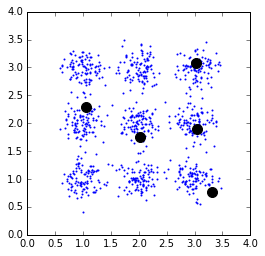

In [58]:
k_means_plus = K_means_plus(points)
init_centroids = k_means_plus.pick_centroids(5)

plot_cluster(points, None, init_centroids)

After several runs, you will find that the initial centroids are more well-distributed than random centroids.

Here is a comparsion between k-means and k-means++. You would not notice a big difference between the result of two algorithms. However, in average, the result of k-means++ will be better than k-means. 

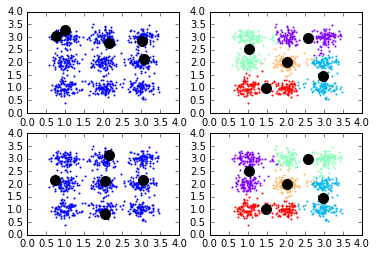

In [59]:
# without k-means ++
K = 5

k_means = K_means(points, K)
k_means.initialize_centroids()

plt.subplot(2, 2, 1)
plot_cluster(points, None, k_means.centroids, True)

clusters, centroids = k_means.k_means()
plt.subplot(2, 2, 2)
plot_cluster(points, clusters, centroids, True)

# with k-mean ++
k_means_plus = K_means_plus(points)
init_centroids = k_means_plus.pick_centroids(K)

plt.subplot(2, 2, 3)
plot_cluster(points, None, init_centroids, True)

k_means = K_means(points, 5)
clusters_p, centroids_p = k_means.k_means(init_centroids)
plt.subplot(2, 2, 4)
plot_cluster(points, clusters_p, centroids_p, True)

# DBSCAN
Density-based spatial clustering of applications with noise (DBSCAN) is another data clustering algorithm. Before we work on this algorithm, let's look at another clustering example using K-means:

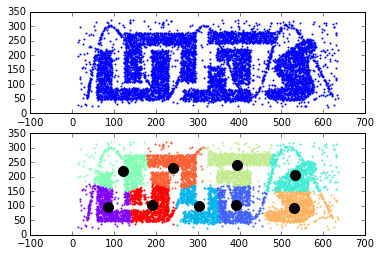

In [60]:
t_points = load_file("t4.8k.txt")

plt.subplot(2, 1, 1)
plot_cluster(t_points, multiple = True)

k_means = K_means(t_points, 9)

t_clusters, t_centroids = k_means.k_means()

plt.subplot(2, 1, 2)
plot_cluster(t_points, t_clusters, t_centroids, True)

Your will find that the k-means clustering is not the correct way to do clustering when we need to identify shape from points. When looking at the sets of points depicted in the previous figure, we can easily detect clusters of points and noise points not belonging to any of those clusters.

Tha main reason why we recognize the clusters is that within each cluster we have a typical density of points which is considerably higher than outside of the clusters.

## DBSCAN
The key idea of DBSCAN is that for each point of a cluster, the neighborhood of a given radius has to contain at least a minimum number of points. The shape of a neighborhood is determined by the choice of a distance function for two points p and q, denoted by dist(p,q). In this tutorial, we will use Euclidean Distance. In the future, you can use other distance, for example, Manhattan distance.

There are two important input parameters for DBSCAN:

1. $\epsilon$: $eps$ is the the radius of neighborhood around a point P.
2. $minPts$: $minPts$ is minimum number of neighbors within “eps” radius.

Other Definition:

1. Eps-neighborhood: The Eps-neighborhood of a point p is defined by $N_Eps (p) = \{q \in D | dist(p,q) \leq Eps\}$. In another word, it is all the points within $\epsilon$ distance of p.

2. Core point: P is a core point if it has at least $minPts$ points within $\epsilon$ distance (Euclideaan Distance) of it (include P).

3. Border point: P is a border point if the number of its neighbors is less than $MinPts$, but it belongs to the Eps-neighborhood of some core point z.

3. Noise point: P is a noise point if it is neither a core or a border point.

<img src="dbscan-principle.png">

This figure shows different type of points. X is a core point, Y is a border point and Z is a noise point

Here is how the algorithm works:
* Loop through all the points
* For each point P
    * Mark P as visited
    * Find all the neighbor points (distance within $\epsilon$)
    * IF number of neighbor points less than $minPts$, mark point as noise
    * ELSE 
        * Assign a new cluter number to P
        * Expand neighbor
    
When we expand the neighbor, we need to find all the neighbor points that are core points and keep expanding until all the neighbor points are noise point. Mark all these core points as visited and assign the same cluster number to them.

In [61]:
from collections import deque

class DBSCAN:
    def __init__(self, points, epsilon, minPts):
        """
        Property:
            points: list of all the points we need to cluster
            minPts: the minumum points within a range
            clusters: list of int, contains the cluster number for each point. -1 means no cluster assgined. 0 means noise point
            unvisited: whether the point has been visited before
            d_matrix: 2-d array indicates whether the distance between X and Y are within range(epsilon)
        """
        e_s, count = epsilon**2, len(points)
        
        self.points = points
        self.minPts = minPts
        self.clusters = np.array([-1] * count)
        self.unvisited = np.array([True] * count)
        
        z = np.array([complex(c[0], c[1]) for c in points])
        m, n = np.meshgrid(z, z)
        self.d_matrix = abs(m-n) < epsilon
                
    def DBSCAN(self):
        """
        Return:
            clusters: A map from cluster number to list of points
        """
        c = 0
        for i, point in enumerate(self.points):
            if self.unvisited[i] == False:
                continue
            else:
                self.unvisited[i] = False

            neighbors = self.find_neighbors(i)
            
            # point i is a noise
            if len(neighbors) < self.minPts:
                self.clusters[i] = 0

            # point i is a core point
            else:
                c += 1
                self.clusters[i] = c
                self.cluster_expend(i, c)

        # Group all the points by cluster number and store all the points within one cluster in a dictionary
        result = {}
        for i in set(self.clusters):
            result[i] = np.array([self.points[pt] for pt in np.argwhere(self.clusters == i).flatten()])
        return result
        pass
                
    def cluster_expend(self, point_index, cluster_index):
        """
        Args:
            point_index: the index of the point we need to extend
            cluster_index: the index of the cluster for the point
        """
        
        neighbors = deque(self.find_neighbors(point_index))
        
        while len(neighbors) > 0:
            # get a new neighborhood
            pt = neighbors.popleft()
            
            if self.unvisited[pt] == True:
                self.unvisited[pt] = False
                new_neighbors = self.find_neighbors(pt)
                
                # if the neighborhood point is not a noise point
                if len(new_neighbors) > self.minPts:
                    # Extend the deque with new neighborhood points
                    neighbors.extend(new_neighbors)
            
            # if the point is not in any clusters
            if self.clusters[pt] == -1:
                self.clusters[pt] = cluster_index
        pass
            
    def find_neighbors(self, point_index):
        """
        Args:
            point_index: the index of the point we need to extend
        Return:
            list of int: All the index of neighbor points that are not visited before
        """
        # use distance matrix to get all the neighborhood points and find all the unvisited neighborhood points
        # then return the index of all these neighborhood points
        return np.nonzero(self.d_matrix[point_index] & self.unvisited)[0]
        pass

This is a simple example help you can test on

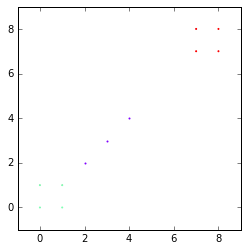

In [62]:
points = np.array([[0,0],[0,1],[1,0], [1,1], [7,7], [7,8],[8,7], [8,8], [4,4], [3,3], [2,2]])
dbscan = DBSCAN(points, 2, 2)
clusters = dbscan.DBSCAN()
# print clusters
plot_cluster(points, clusters)

Wall time: 3.88 s
Wall time: 619 ms


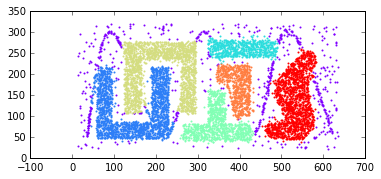

In [63]:
t_points = load_file("t4.8k.txt")
%time dbscan = DBSCAN(t_points, 15, 25)
%time t_clusters_dbscan = dbscan.DBSCAN()
plot_cluster(t_points, t_clusters_dbscan)

Now you can play with everything! Other files provided with this tutorial and you can test all of them.

### K Nearest Neighbors
You may notice that the $epslion$ and $minPts$ values are hard to choose. If you cannot choose a correct $epslion$ based on a $minPts$ value, the number of clusters might be too much or too little. Now let me how you how to determin the optimal eps value.

The idea is to calculate, the average of the distances of every point to its k nearest neighbors. The value of k will be specified by the user and corresponds to MinPts. Next, these k-distances are plotted in an ascending order against different size of sample points. The aim is to determine the “knee”, which corresponds to the optimal eps parameter.

In [64]:
def k_distance(points, k):
    z = np.array([complex(c[0], c[1]) for c in points])
    m, n = np.meshgrid(z, z)
    d_matrix = abs(m-n)
    return np.mean(np.sort(d_matrix, axis = 1)[:,:k])

def plot_k_distance(points, k):
    step_size = len(points)/20
    sample_size = range(step_size,len(points),step_size)
    k_diss = []
    for i in sample_size:
        sample = random.sample(range(1, len(points)), i)
        k_diss.append(k_distance(points[sample],k))

    plt.plot(sample_size, k_diss)

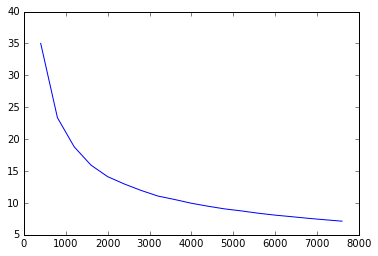

In [65]:
# print k_distance(t_points, 4)
plot_k_distance(t_points, 25)

## Reference
1. K-means clustering, https://en.wikipedia.org/wiki/K-means_clustering
2. Cluster Analysis: Basic Concept and Algorithms, https://www-users.cs.umn.edu/~kumar/dmbook/ch8.pdf
3. K-means ++ algoright, https://datasciencelab.wordpress.com/2014/01/15/improved-seeding-for-clustering-with-k-means/
4. DBSCAN, https://en.wikipedia.org/wiki/DBSCAN
5. A Density-Based Algorithm for Discovering Clusters, http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf
6. density-based clustering for discovering clusters in large datasets with noise - Unsupervised Machine Learning, http://www.sthda.com/english/wiki/dbscan-density-based-clustering-for-discovering-clusters-in-large-datasets-with-noise-unsupervised-machine-learning